(stochastic_volatility)=
# Stochastic Volatility model

:::{post} June 17, 2022
:tags: time series, case study
:category: beginner
:author: John Salvatier
:::

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

rng = np.random.RandomState(1234)
az.style.use("arviz-darkgrid")

Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. The following model is similar to the one described in the No-U-Turn Sampler paper, {cite:p}`hoffman2014nuts`.

$$ \sigma \sim Exponential(50) $$

$$ \nu \sim Exponential(.1) $$

$$ s_i \sim Normal(s_{i-1}, \sigma^{-2}) $$

$$ \log(r_i) \sim t(\nu, 0, \exp(-2 s_i)) $$

Here, $r$ is the daily return series and $s$ is the latent log volatility process.

## Build Model

First we load daily returns of the S&P 500, and calculate the daily log returns. This data is from May 2008 to November 2019.

In [2]:
try:
    returns = pd.read_csv(os.path.join("..", "data", "SP500.csv"), index_col="Date")
except FileNotFoundError:
    returns = pd.read_csv(pm.get_data("SP500.csv"), index_col="Date")

returns["change"] = np.log(returns["Close"]).diff()
returns = returns.dropna()

returns.head()

,Close,change
Date,,
2008-05-05,1407.489990,-0.004544
2008-05-06,1418.260010,0.007623
2008-05-07,1392.569946,-0.018280
2008-05-08,1397.680054,0.003663
2008-05-09,1388.280029,-0.006748


As you can see, the volatility seems to change over time quite a bit but cluster around certain time-periods. For example, the 2008 financial crisis is easy to pick out.

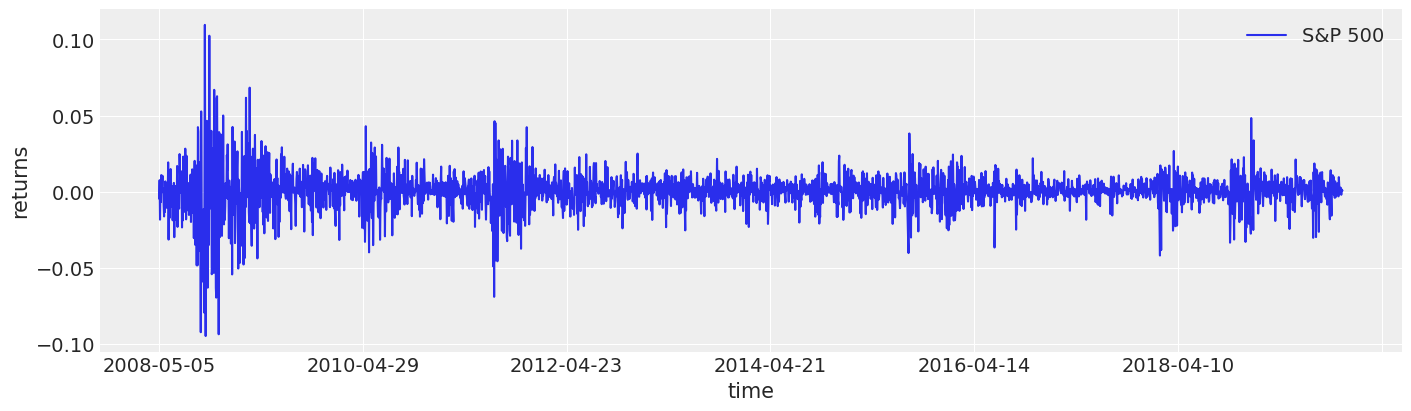

In [3]:
fig, ax = plt.subplots(figsize=(14, 4))
returns.plot(y="change", label="S&P 500", ax=ax)
ax.set(xlabel="time", ylabel="returns")
ax.legend();

Specifying the model in `PyMC` mirrors its statistical specification.

In [4]:
def make_stochastic_volatility_model(data):
    with pm.Model(coords={"time": data.index.values}) as model:
        step_size = pm.Exponential("step_size", 10)
        volatility = pm.GaussianRandomWalk(
            "volatility", sigma=step_size, dims="time", init_dist=pm.Normal.dist(0, 100)
        )
        nu = pm.Exponential("nu", 0.1)
        returns = pm.StudentT(
            "returns", nu=nu, lam=np.exp(-2 * volatility), observed=data["change"], dims="time"
        )
    return model


stochastic_vol_model = make_stochastic_volatility_model(returns)

## Checking the model

Two good things to do to make sure our model is what we expect is to 
1. Take a look at the model structure. This lets us know we specified the priors we wanted and the connections we wanted. It is also handy to remind ourselves of the size of the random variables.
2. Take a look at the prior predictive samples. This helps us interpret what our priors imply about the data.

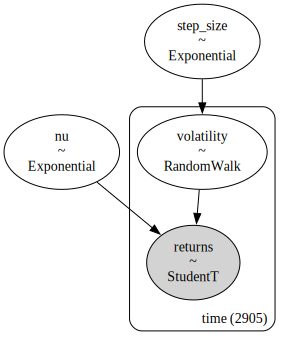

In [5]:
pm.model_to_graphviz(stochastic_vol_model)

In [6]:
with stochastic_vol_model:
    idata = pm.sample_prior_predictive(500, random_seed=rng)

prior_predictive = idata.prior_predictive.stack(pooled_chain=("chain", "draw"))

Sampling: [nu, returns, step_size, volatility]


We plot and inspect the prior predictive. This is *many* orders of magnitude larger than the actual returns we observed. In fact, I cherry-picked a few draws to keep the plot from looking silly. This may suggest changing our priors: a return that our model considers plausible would violate all sorts of constraints by a huge margin: the total value of all goods and services the world produces is ~$\$10^9$, so we might reasonably *not* expect any returns above that magnitude.

That said, we get somewhat reasonable results fitting this model anyways, and it is standard, so we leave it as is.

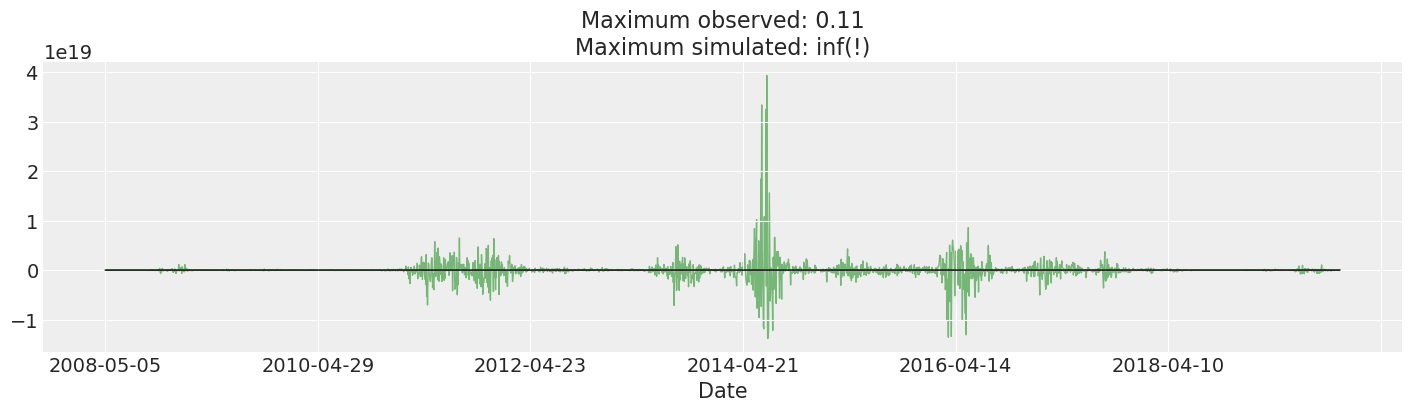

In [7]:
fig, ax = plt.subplots(figsize=(14, 4))
returns["change"].plot(ax=ax, lw=1, color="black")
ax.plot(
    prior_predictive["returns"].isel(pooled_chain=slice(4, 6, None)),
    "g",
    alpha=0.5,
    lw=1,
    zorder=-10,
)

max_observed, max_simulated = np.max(np.abs(returns["change"])), np.max(
    np.abs(prior_predictive["returns"].values)
)
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

## Fit Model

Once we are happy with our model, we can sample from the posterior. This is a somewhat tricky model to fit even with NUTS, so we sample and tune a little longer than default.

In [8]:
with stochastic_vol_model:
    idata.extend(pm.sample(2000, tune=2000, random_seed=rng))

posterior = idata.posterior.stack(pooled_chain=("chain", "draw"))
posterior["exp_volatility"] = np.exp(posterior["volatility"])

c:\Anaconda\envs\pymc-dev\Lib\site-packages\pymc\logprob\joint_logprob.py:167: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
c:\Anaconda\envs\pymc-dev\Lib\site-packages\pymc\logprob\joint_logprob.py:167: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Anaconda\envs\pymc-dev\Lib\site-packages\pymc\logprob\joint_logprob.py:167: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
c:\Anaconda\envs\pymc-dev\Lib\site-packages\pymc\logprob\joint_logpro

ValueError: Not enough samples to build a trace.

In [ ]:
with stochastic_vol_model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=rng))

posterior_predictive = idata.posterior_predictive.stack(pooled_chain=("chain", "draw"))

Sampling: [returns]


Note that the `step_size` parameter does not look perfect: the different chains look somewhat different. This again indicates some weakness in our model: it may make sense to allow the step_size to change over time, especially over this 11 year time span.

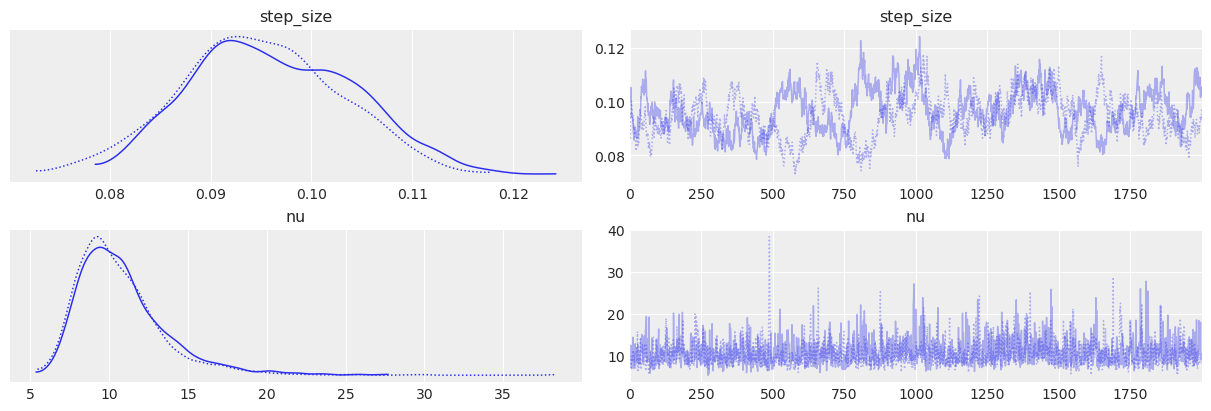

In [ ]:
az.plot_trace(idata, var_names=["step_size", "nu"]);

Now we can look at our posterior estimates of the volatility in S&P 500 returns over time.

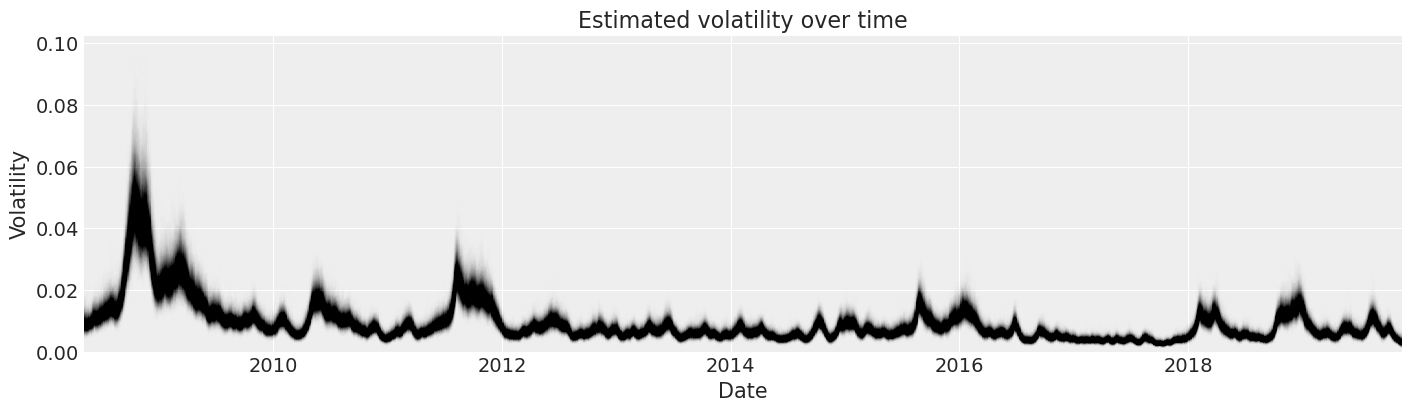

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 5))
x_vals = y_vals.time.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

Finally, we can use the posterior predictive distribution to see the how the learned volatility could have effected returns.

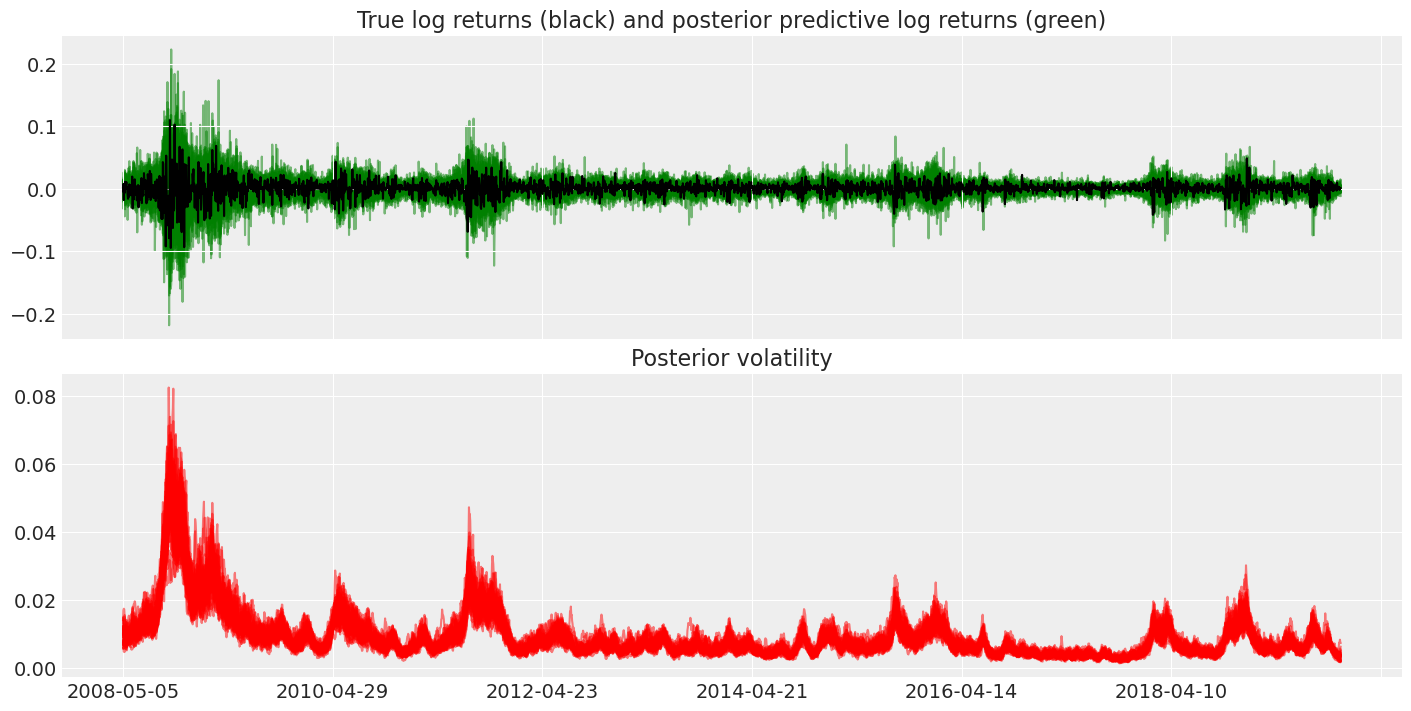

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
returns["change"].plot(ax=axes[0], color="black")

axes[1].plot(posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 100)), "r", alpha=0.5)
axes[0].plot(
    posterior_predictive["returns"].isel(pooled_chain=slice(None, None, 100)),
    "g",
    alpha=0.5,
    zorder=-10,
)
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")
axes[1].set_title("Posterior volatility");

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Tue Jan 31 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.8.0

pytensor: 2.9.1
aeppl   : 0.1.0
xarray  : 2022.12.0

sys       : 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:12:32) [MSC v.1929 64 bit (AMD64)]
pymc      : 5.0.2
numpy     : 1.24.1
pandas    : 1.5.2
matplotlib: 3.6.2
arviz     : 0.14.0

Watermark: 2.3.1



## References

:::{bibliography}
:filter: docname in docnames
:::

## Authors

* Written by John Salvatier
* Updated by Kyle Meyer
* Updated by Thomas Wiecki
* Updated by Chris Fonnesbeck
* Updated by Aaron Maxwell on May 18, 2018 ([pymc#2978](https://github.com/pymc-devs/pymc/pull/2978))
* Updated by Colin Carroll on November 16, 2019 ([pymc#3682](https://github.com/pymc-devs/pymc/pull/3682))
* Updated by Abhipsha Das on July 24, 2021 ([pymc-examples#155](https://github.com/pymc-devs/pymc-examples/pull/155))
* Updated by Michael Osthege on June 1, 2022 ([pymc-examples#343](https://github.com/pymc-devs/pymc-examples/pull/343))
* Updated by Christopher Krapu on June 17, 2022 ([pymc-examples#378](https://github.com/pymc-devs/pymc-examples/pull/378))
* Updated for compatibility with PyMC v5 by Beryl Kanali and Sangam Swadik on Jan 22, 2023 ([pymc-examples#517](https://github.com/pymc-devs/pymc-examples/pull/517))

:::{include} ../page_footer.md
:::